In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.gaussian_process import GaussianProcess

Populating the interactive namespace from numpy and matplotlib


In [2]:
## TOOLS ##
###########

# Find border indices of sampling windows in data
def pick_sampling_windows(timestamps):
    dt = []
    for i in xrange(1, len(timestamps)):
        dt.append(timestamps[i]-timestamps[i-1])
    dt_threshold = np.mean(dt)*1.
    right_ends = np.append(np.where(dt>=dt_threshold)[0], len(timestamps)-1)
    left_ends = np.append(0, np.where(dt>=dt_threshold)[0]+1)
    windows = np.zeros((len(right_ends), 2))
    for i in range(0, len(right_ends)):
        windows[i] = (left_ends[i], right_ends[i])
    return windows

# Make a GaussianProcess model for noisy data
def make_a_model(pairNo, x, X, y, dy, theta0=1e-3, thetaL=1e-3, thetaU=1):
    gp = GaussianProcess(corr='squared_exponential', # If the original experiment is known to be infinitely differentiable (smooth), then one should use the squared-exponential correlation model.
                         regr = "quadratic", #?
                         theta0 = 1e-1,
                         thetaL = 1e-1,
                         thetaU = 1e-1,
                         nugget = (dy / y) ** 2, #?
                         random_start=500)
# Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, MSE = gp.predict(x, eval_MSE=True)
    sigma = np.sqrt(MSE)
    return y_pred, sigma

# Make a GaussianProcess model for data without noise (It complains for TDC dataset though!)
def make_a_perfect_model(pairNo, x, X, y):
    gp = GaussianProcess(theta0=1e-3,
                         thetaL=1e-3,
                         thetaU=1,
                         random_start=500)
# Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, MSE = gp.predict(x, eval_MSE=True)
    sigma = np.sqrt(MSE)
    return y_pred, sigma

# Plot data points with error bars
def plot_data(pairNo, dt, X, y, dy, ob):
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
    plt.errorbar(X.ravel() + dt, y, dy, fmt='.', markersize=10, label='Observations ' + ob)

# Plot the best-fit model of data along with 95% uncertainties
def plot_model(pairNo, dt, x, y_pred, sigma, ob):
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
    plt.plot(x + dt, y_pred, '-', label='Prediction ' + ob)
    plt.fill(np.concatenate([x + dt, x[::-1] + dt]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, ec='None', label='95% confidence interval ' + ob)

# Cross correlate two arrays (models or data!) and return the index of the maximum correlation and the full corr array
def cross_correlate_models(model1, model2, mode='same'):
    corr = correlate(model1, model2, mode=mode)
    abscorr = np.abs(corr)
    maxcorr = np.max(abscorr)
    return np.where(abscorr == maxcorr)[0], corr


window 0 ...


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


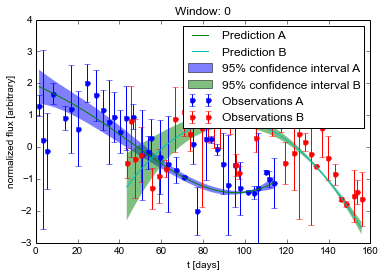

Window0 done!
window 1 ...


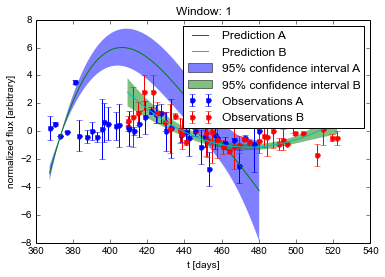

Window1 done!
window 2 ...


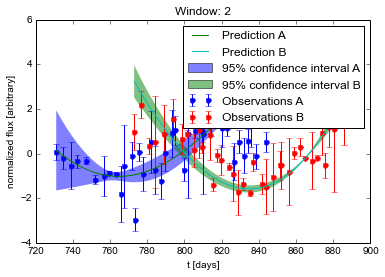

Window2 done!
window 3 ...


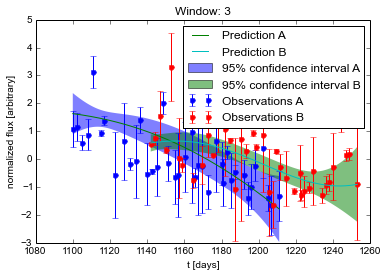

Window3 done!
window 4 ...


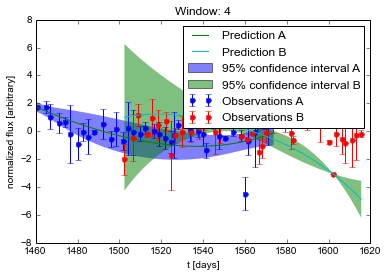

Window4 done!


In [ ]:
# Fit GP model to each sampling window of the data separately
N_eval = 5000
pairNo = 9
dt_true = 41.9
lightcurve = np.loadtxt("/home/saas9842/PhD/Courses/AstroML/Project/tdc1/rung3/tdc1_rung3_double_pair%d.txt"%(pairNo),
                        skiprows=6, dtype={"names":("time", "lcA", "errA", "lcB", "errB"), 
                                           "formats":("f4", "f4", "f4", "f4", "f4")})

windows = pick_sampling_windows(lightcurve['time'])
modelA = np.zeros((N_eval * len(windows), 2))
modelB = np.zeros((N_eval * len(windows), 2))
t_maxcorr = np.zeros((len(windows), ))
t_eval = np.zeros((N_eval * len(windows), 1))

for i, window in enumerate(windows):
    print "window " + str(i) + " ..."
    
    data = lightcurve[window[0]:window[1]]
    t_eval[N_eval*i:N_eval*(i+1)] = np.atleast_2d(np.linspace(np.min(data['time']), np.max(data['time']), N_eval)).T
    
# find the best-fit model for LC A
    XA = data['time'].T
    XA = XA.reshape((len(XA), 1))
    fA = (data['lcA'] - np.mean(data['lcA'])) / np.std(data['lcA'])
    dfA = (data['errA'] - np.mean(data['errA'])) / np.std(data['errA'])
    modelA[N_eval*i:N_eval*(i+1), 0], modelA[N_eval*i:N_eval*(i+1), 1] = make_a_model(pairNo, 
                                                                                      t_eval[N_eval*i:N_eval*(i+1)], 
                                                                                      XA, fA, dfA) # image A

# find the best-fit model for LC B
    XB = data['time'].T
    XB = XB.reshape((len(XB), 1))
    fB = (data['lcB'] - np.mean(data['lcB'])) / np.std(data['lcB'])
    dfB = (data['errB'] - np.mean(data['errB'])) / np.std(data['errB'])
    modelB[N_eval*i:N_eval*(i+1), 0], modelB[N_eval*i:N_eval*(i+1), 1] = make_a_model(pairNo, 
                                                                                      t_eval[N_eval*i:N_eval*(i+1)], 
                                                                                      XB, fB, dfB) # image B

    # Cross correlate the two models
    ind_maxcorr, corr = cross_correlate_models(modelA[N_eval*i:N_eval*(i+1), 0],
                                               modelB[N_eval*i:N_eval*(i+1), 0])
    maxcorr = t_eval[ind_maxcorr]
    t_maxcorr[i] = maxcorr[0][0]
    
    plt.figure()
###  plot_model(pairNo, dt, x, y_pred, sigma, ob)   

    plot_data(pairNo, 0, XA, fA, dfA, "A") #A
    plot_model(pairNo, 0, 
               t_eval[N_eval*i:N_eval*(i+1)], 
               modelA[N_eval*i:N_eval*(i+1), 0], 
               modelA[N_eval*i:N_eval*(i+1), 1],
               "A ") #A
    
    plot_data(pairNo, dt_true, XB, fB, dfB, "B") #B
    plot_model(pairNo, dt_true, 
               t_eval[N_eval*i:N_eval*(i+1)], 
               modelB[N_eval*i:N_eval*(i+1), 0], 
               modelB[N_eval*i:N_eval*(i+1), 1],
               "B ") #B
    
#    plt.plot(x, (corr - np.mean(corr)) / np.std(corr),
#             '-y', linewidth=3, label="Cross correlation")
    plt.xlabel('t [days]')
    plt.ylabel('normalized flux [arbitrary]')
    plt.title("Window: " + str(i))
#    plt.title('PairNo: ' + str(pairNo) +
#              ' - true time delay: ' + str(dt_true) +
#              ' - maximum correlation at: ' + str(t_maxcorr))
    
    plt.legend().draggable()
#    plt.savefig("window" + str(i) + ".png")
    plt.show()
    print "Window" + str(i) + " done!"

In [ ]:
# Gaussian Process
#dt_trues = [-57.53, -33.49, -108.85, 71.03, -33.82, -62.04, -61.6, -73.6, 41.9, 104.22]
periods = []
dt_preds = []
dt_trues = [41.9]#, 104.22]
for pairNo, dt_true in zip(range(9, 10), dt_trues):
    lightcurve = np.loadtxt("/home/saas9842/PhD/Courses/AstroML/Project/tdc1/rung3/tdc1_rung3_double_pair%d.txt"%(pairNo),
                            skiprows=6, dtype={"names":("time", "lcA", "errA", "lcB", "errB"), 
                                               "formats":("f4", "f4", "f4", "f4", "f4")})
    x = np.atleast_2d(np.linspace(0, np.max(lightcurve['time']), 5000)).T
    XA = lightcurve['time'].T
    XA = XA.reshape((len(XA), 1))
    yA = (lightcurve['lcA'] - np.mean(lightcurve['lcA'])) / np.std(lightcurve['lcA'])
    dyA = lightcurve['errA']
    y_predA, sigmaA = make_a_model(pairNo, x, XA, yA, dyA, theta0=1e-3, thetaL=1e-3, thetaU=1) #A

    
    XB = (lightcurve['time']).T
    XB = XB.reshape((len(XB), 1))
    yB = (lightcurve['lcB'] - np.mean(lightcurve['lcB'])) / np.std(lightcurve['lcB'])
    dyB = lightcurve['errB']
    y_predB, sigmaB = make_a_model(pairNo, x, XB, yB, dyB, theta0=1e-3, thetaL=1e-3, thetaU=1) #B
    

# Cross correlate the two models
    ind_maxcorr, corr = cross_correlate_models(y_predA, y_predB)
    t_maxcorr = x[ind_maxcorr]
    t_maxcorr = t_maxcorr[0][0]

# Autcorelate each of the models for an estimate of their periods individually
    ind_max_acfA, corrA = cross_correlate_models(y_predA, y_predA)
    t_max_acfA = x[ind_max_acfA]
    t_max_acfA = t_max_acfA[0][0]

    ind_max_acfB, corrB = cross_correlate_models(y_predB, y_predB)
    t_max_acfB = x[ind_max_acfB]
    t_max_acfB = t_max_acfB[0][0]

    periods.append(t_max_acfB)
    dt_preds.append(t_maxcorr)
    
    print "Pair " + str(pairNo) + " done!"
    
    # Plot everything
    plt.figure()

    plot_data(pairNo, 0, XA, yA, dyA, "A") # A
    plot_model(pairNo, 0, x, y_predA, sigmaA,"A ") # A
    
    plot_data(pairNo, 0, XB, yB, dyB, "B") # B
    plot_model(pairNo, 0, x, y_predB, sigmaB,"B ") # B
    
    plt.plot(x, (corr - np.mean(corr)) / np.std(corr),
             '-y', linewidth=3, label="Cross correlation")
    plt.xlabel('t [days]')
    plt.ylabel('normalized flux [arbitrary]')
    plt.title('PairNo: ' + str(pairNo) +
              ' - true time delay: ' + str(dt_true) +
              ' - maximum correlation at: ' + str(t_maxcorr))
    
    plt.legend().draggable()
    plt.show()

In [12]:
# Investigate the correlations for the outputs of Gaussian Process modeling; period, maximum correlation, true time delay
periods = np.array(periods)
dt_trues = np.array(dt_trues)
dt_preds = np.array(dt_preds)

plt.figure()
plt.scatter(dt_trues, periods, marker='o', c=periods, edgecolor='None', s=150)
plt.plot(dt_trues, dt_trues, linewidth=3)
plt.show()

plt.figure()
plt.scatter(dt_trues, periods, marker='o', c=dt_preds, edgecolor='None', s=150)
plt.plot(dt_trues, dt_trues, linewidth=3)
plt.show()

In [20]:
## GPR


104.22 42.3452325231
